## Импорты

In [1]:
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

## EDA

In [2]:
filepath = './train_dataset.csv'
df = pd.read_csv(filepath)
df['date'] = pd.to_datetime(df['date']) # Преобразуем столбец с датой в формат datetime
print('Размер датафрейма:', df.shape)
display(df.head())

Размер датафрейма: (37224, 7)


,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          37224 non-null  datetime64[ns]
 1   time          37224 non-null  int64         
 2   target        37224 non-null  float64       
 3   temp          37224 non-null  float64       
 4   temp_pred     37136 non-null  float64       
 5   weather_pred  37136 non-null  object        
 6   weather_fact  37223 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 2.0+ MB


Есть категориальные данные, нужно будет закодировать 

In [4]:
df.isna().sum()

date             0
time             0
target           0
temp             0
temp_pred       88
weather_pred    88
weather_fact     1
dtype: int64

Есть пропуски. Поскольку работаем с временными рядами - то пропущенные значения можем заполнить значением из предыдущей строки

In [5]:
df.describe()

,date,time,target,temp,temp_pred
count,37224,37224.00000,37224.000000,37224.000000,37136.000000
mean,2021-02-14 00:00:00,11.50000,483.731441,8.748995,8.768984
min,2019-01-01 00:00:00,0.00000,198.982000,-21.700000,-20.000000
25%,2020-01-23 00:00:00,5.75000,418.950750,2.600000,3.000000
50%,2021-02-14 00:00:00,11.50000,473.064000,7.900000,8.000000
75%,2022-03-09 00:00:00,17.25000,561.217000,14.700000,15.000000
max,2023-03-31 00:00:00,23.00000,767.888000,32.500000,33.000000
std,NaN,6.92228,101.459375,8.125722,8.017520


Необходимо нормализовать значения

Выведем график температур и потребления электроэнергии

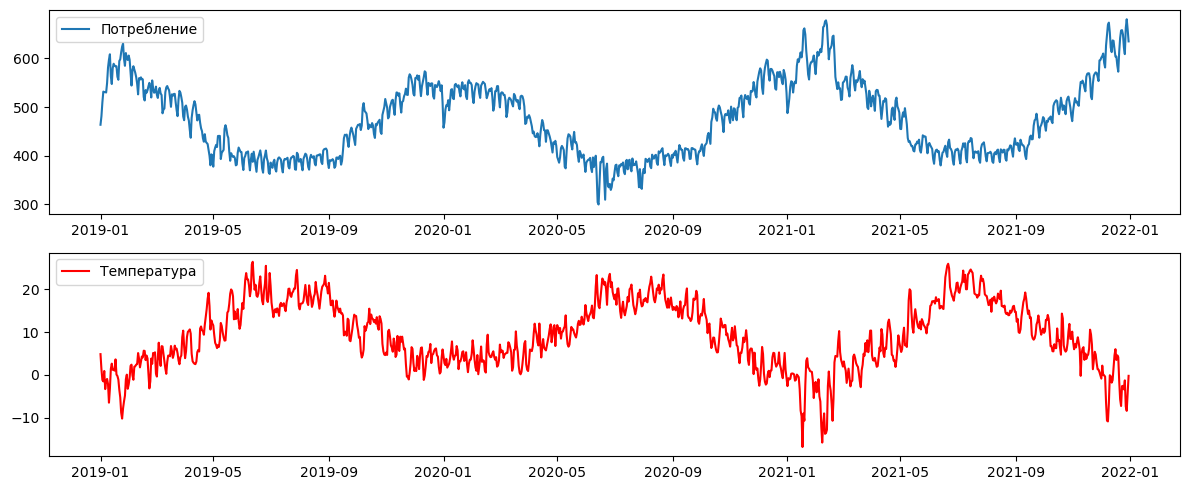

In [6]:
df_daily = df.groupby('date')[['target', 'temp']].mean().reset_index()

n = 1095
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(df_daily['date'][:n], df_daily['target'][:n], label='Потребление')
plt.legend(loc='upper left')
plt.xticks(rotation=0)

plt.subplot(2, 1, 2)
plt.plot(df_daily['date'][:n], df_daily['temp'][:n], label='Температура', color='red')
plt.legend(loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()


## Class Preprocessor

In [7]:
dct_to_replace = {

    'ливневый|ливн|ливнем|ливни': 'ливень',
    'краткосрочно|кр|вр|временами|временный|врем': 'краткосрочный',
    
    'снежная|снегопад|снегом|обледенение|снеж|снегодождь|ледяной|снежные|снежок|сн|пурга|метель|с|лед|лёд': 'снег',
    'сн дождь': 'снег дождь',
    'мокр|сыро': 'мокрый',
    'сухие': 'сухой',
    
    'крапает|дождик|дождем|дожди|дожь': 'дождь',

    'сев': 'северный',
    'востоке|вост': 'восточный',
    'юго': 'южный',
    'зап': 'западный',
    
    'градом': 'град',
    'грозы|гром': 'гроза',
    'молнии': 'молния',
    'солнце': 'солнечно',
    'душно|душновато': 'жарко',
    'тает|комфортно|комфорт': 'тепло',
    'осадков': 'осадки',
    'шт': 'шторм',

    'ветра|порывы|порыв|ветерок|ветрище|ветерк|ветром': 'ветер',

    'моровь|морось|морос|моромь|слепой|изморозь': 'мороз',
 
    'хол|прохладно|иней|заморозки|поземка|поземный': 'холодно',
 
    'очень|затяж|сплошн|сплош|сплошная|круп|крупный|преим|сильный|сил|крупа|проливной|оч|густой|интенсивности|разной': 'много',

    'тихий|легкий|легкая|легк|зябко|мелкий|слаб|слабый|слабая|неб|небольшой|мало|штиль': 'лёгкий',

    'возможна|возм|в|мест|мастами|местами': 'возможно',

    'перем|пер|п': 'переменная',
    
    'облс|об|обл|облч|облач|облачн|облачность|пушистый|хлопьями': 'облачно',
    
    'малообл|малобл|малооб|перообл': 'переменная облачно',

    'обл с пр|обл с проясн': 'облачно прояснения',
    
    'проясн|пр|просн|прясн': 'прояснения',

    'пасмурн|пасм': 'пасмурно',
    
    'яснно': 'ясно',

    'д|без|со|сп|спл|нег|пнр|пеп|мухи|все|сл|пам|стеной|минут|расс|на|ощ|и': '',
    'мм': ''
    # '1мм|9мм|3мм|5мм|8мм|6мм|7мм|4мм|0мм|2мм': ''
}

unique_words = ['гроза', 'сухой', 'осадки', 'возможно', 'переменная', 'тучи', 'восточный', 'ветер', 'град',
                'ливень', 'облачно', 'холодно', 'снег', 'туман', 'дождь', 'прояснения', 'солнечно', 'шторм',
                'мокрый', 'дымка', 'краткосрочный', 'пасмурно', 'жарко', 'много', 'малооблачно', 'северный',
                'молния', 'тепло', 'мороз', 'ясно', 'лед', 'лёгкий']

In [10]:
class Preprocessor:
    def __init__(self, filepath):
        if os.path.exists(filepath):
            self.df = pd.read_csv(filepath)
            print('Размер датафрейма:', self.df.shape)
            display(self.df.head())
        else:
            raise Exception('file not exists')
    
    def fill_empty_cells(self):
        print('INFO: Заполнение пустых значений')
        self.df['temp_pred'].fillna(method='ffill', inplace=True)
        self.df['weather_pred'].fillna(method='ffill', inplace=True)
        self.df['weather_fact'].fillna(method='ffill', inplace=True)
        print('Пропущенных значений:', self.df.isna().sum().sum(), '\n')
    
    def shift_target(self):
        print('INFO: Смещение target на сутки назад')
        last_24_target = self.df['target'].tail(24).tolist()
        self.df['target'] = self.df['target'].shift(-24)
        self.df.iloc[-24:, self.df.columns.get_loc('target')] = last_24_target
        print(self.df.shape, '\n')
        
    def add_features(self):
        print('INFO: Добавление полезных фичей')
        self.df['date'] = pd.to_datetime(self.df['date'])                               # Столбец Date в формат datetime
        self.df['day_of_week'] = self.df['date'].dt.dayofweek                           # Номер дня в неделе
        self.df['month'] = self.df['date'].dt.month                                     # Номер месяца
        self.df['year'] = self.df['date'].dt.year                                       # Номер года
        self.df['date'] = (self.df['date'] - self.df['date'].min()).dt.days             # Дату в количество прошедших дней с начальной даты

        self.df['target_t_1'] = self.df['target'].shift(1)                              # Значение target на предыдущий час
        self.df['target_t_24'] = self.df['target'].shift(24)                            # Значение target на предыдущий день
        self.df['target_avg5'] = self.df['target'].rolling(window=5).mean()             # Среднее значение target за предыдущие 5 часов
        self.df['target_avg24'] = self.df['target'].rolling(window=24).mean()           # Среднее значение target за предыдущие 24 часа

        self.df['temp_pred_avg5'] = self.df['temp_pred'].rolling(window=5).mean()       # Среднее значение temp_pred за предыдущие 5 часов
        self.df['temp_pred_avg24'] = self.df['temp_pred'].rolling(window=24).mean()     # Среднее значение temp_pred за предыдущие 24 часа
        self.df['temp_avg5'] = self.df['temp'].rolling(window=5).mean()                 # Среднее значение temp за предыдущие 5 часов
        self.df['temp_avg24'] = self.df['temp'].rolling(window=24).mean()               # Среднее значение temp за предыдущие 24 часа
        for i in ['target', 'temp', 'temp_pred']:   
            self.df[f'{i}_derivative_1'] = self.df[i].diff()                            # Производная 1 порядка
            self.df[f'{i}_derivative_2'] = self.df[i].diff()                            # Производная 2 порядка
            self.df[f'{i}_inverse'] = 1 / (self.df[i] + 0.01)                           # Обратное значение                                           ##########
            
        print('Размер датафрейма:', self.df.shape, '\n')
        
    @staticmethod
    def extract_numbers(text):
        """Ищем числа в строке (вероятности возникновения погодного события)."""
        numbers = re.findall(r'\d+', text)
        lst = [int(num) for num in numbers]
        if len(lst) == 0:
            return 0
        return max(lst)

    @staticmethod
    def replace_strange_chars(text):
        """Удаляем все символы, оставляем только слова, удаляем лишние пробелы, переводим в lowercase."""
        cleaned_text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', ' ', text)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
        return cleaned_text.strip().lower()

    @staticmethod
    def replaced_words(row):
        """Заменяем слова из строки по совпадению ключей словаря на значения."""
        for pattern, replacement in dct_to_replace.items():
            row = re.sub(r'\b(?:' + pattern + r')\b', replacement, row)
        return row

    @staticmethod
    def get_hist(values, bins):
        """Выводим график распределения слов о погодных условиях."""
        print('Слов в столбцах weather_pred и weather_fact:', len(values))
        print('Уникальных слов описывающих погодные условия:', len(bins))
        plt.hist(values, bins=len(bins), color='green')
        plt.xticks(rotation=90)
        plt.show()
    
    @staticmethod
    def save_dataset(X_train, X_test, y_train, y_test, df):
        """Сохраняем X_train, X_test, y_train, y_test и предобработанный датафрейм."""
        np.save('./X_train.npy', X_train)
        np.save('./X_test.npy', X_test)
        np.save('./y_train.npy', y_train)
        np.save('./y_test.npy', y_test)
        df.to_csv('./df_preprocessed.csv', index=False)

    @staticmethod
    def load_dataset():
        """Загружаем X_train, X_test, y_train, y_test и df."""
        X_train = np.load('./X_train.npy')
        X_test = np.load('./X_test.npy')
        y_train = np.load('./y_train.npy')
        y_test = np.load('./y_test.npy')
        df = pd.read_csv('./df_preprocessed.csv')
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        return X_train, X_test, y_train, y_test, df

    def one_hot_encoding(self):
        print('INFO: Кодирование категориальных столбцов')
        print('INFO:', self.extract_numbers.__doc__, '\n')
        self.df['probability_pred'] = self.df['weather_pred'].apply(self.extract_numbers)
        self.df['probability_fact'] = self.df['weather_fact'].apply(self.extract_numbers)
        print('INFO:', self.replace_strange_chars.__doc__, '\n')
        self.df['weather_pred'] = self.df['weather_pred'].apply(self.replace_strange_chars)
        self.df['weather_fact'] = self.df['weather_fact'].apply(self.replace_strange_chars)
        print('INFO:', self.replaced_words.__doc__, '\n')
        self.df['weather_pred'] = self.df['weather_pred'].apply(self.replaced_words)
        self.df['weather_fact'] = self.df['weather_fact'].apply(self.replaced_words)
        # Разделяем строки на слова
        self.df['weather_pred'] = self.df['weather_pred'].str.split()
        self.df['weather_fact'] = self.df['weather_fact'].str.split()
        # Получаем уникальные значения
        # unique_pred = set(word for words in self.df['weather_pred'] for word in words)
        # unique_fact = set(word for words in self.df['weather_fact'] for word in words)
        # merged_set = unique_pred | unique_fact
        # print(merged_set)
        # Создаем новые столбцы для каждого уникального значения
        for word in unique_words:
            self.df[word + '_pred'] = self.df['weather_pred'].apply(lambda x: int(word in x))
            self.df[word + '_fact'] = self.df['weather_fact'].apply(lambda x: int(word in x))
        
        # Немного анализа
        self.df['Combined'] = self.df['weather_pred'].str.join(' ') + ' ' + self.df['weather_fact'].str.join(' ')
        self.df['Words'] = self.df['Combined'].str.split()
        all_values = [word for words_list in  self.df['Words'] for word in words_list]
        unique_values = list(set(all_values))
        print('INFO:', self.get_hist.__doc__, '\n')
        self.get_hist(all_values, unique_values)

        # Удаляем исходные категориальные переменные
        self.df = self.df.drop(['weather_pred', 'weather_fact', 'Combined', 'Words'], axis=1)
        print('Размер датафрейма:', self.df.shape)
    
    def create_x_y(self, train_test=False):
        print('INFO: Создание набора данных')
        X = np.array(self.df.drop('target', axis=1))
        y = np.array(self.df['target'])
        if not train_test:
            print(X.shape, y.shape)
            return X, y 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        # print('INFO:', self.save_dataset.__doc__, '\n')
        # self.save_dataset(X_train, X_test, y_train, y_test, self.df)
        return X_train, X_test, y_train, y_test

## Preprocessing

In [11]:
filepath = './train_dataset.csv'
sol = Preprocessor(filepath)

Размер датафрейма: (37224, 7)


,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"


In [12]:
# Поскольку работаем с временными рядам, то можно заполнить пропущенные значения значениями предыдущих строк
sol.fill_empty_cells()

# Поскольку нам необходимо предсказывать потребление электричества на сутки вперед, то сдвинем метки на 24 строки вверх
# sol.shift_target()  #####???#####

# Добавим полезные фичи
sol.add_features()

INFO: Заполнение пустых значений
Пропущенных значений: 0 

INFO: Добавление полезных фичей
Размер датафрейма: (37224, 27) 



Теперь нужно распарсить столбцы о погодных условиях и закодировать. Или трансформировать столбцы в эмбеддинги (на размышление)
1. Вынести вероятности возникновения погодного события (50%, 30%) в отдельный столбец
2. Стандартизировать слова и закодировать в OHE

INFO: Кодирование категориальных столбцов
INFO: Ищем числа в строке (вероятности возникновения погодного события). 

INFO: Удаляем все символы, оставляем только слова, удаляем лишние пробелы, переводим в lowercase. 

INFO: Заменяем слова из строки по совпадению ключей словаря на значения. 

INFO: Выводим график распределения слов о погодных условиях. 

Слов в столбцах weather_pred и weather_fact: 132866
Уникальных слов описывающих погодные условия: 31


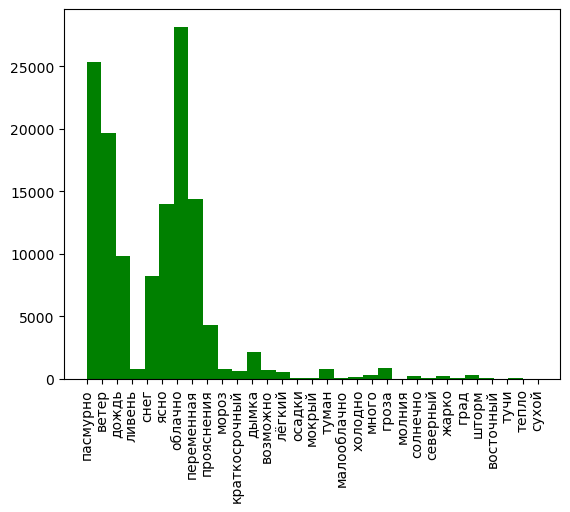

Размер датафрейма: (37224, 91)


In [12]:
sol.one_hot_encoding()

In [13]:
n = 6600
sol.df[n:n+5]

,date,time,target,temp,temp_pred,day_of_week,month,year,target_t_1,target_t_24,...,тепло_pred,тепло_fact,мороз_pred,мороз_fact,ясно_pred,ясно_fact,лед_pred,лед_fact,лёгкий_pred,лёгкий_fact
6600,0,0,424.715,6.5,8.0,3,1,1970,471.278,416.892,...,0,0,0,0,0,0,0,0,0,0
6601,0,1,382.598,6.5,8.0,3,1,1970,424.715,377.052,...,0,0,0,0,0,0,0,0,0,0
6602,0,2,358.989,6.5,8.0,3,1,1970,382.598,352.482,...,0,0,0,0,0,0,0,0,0,0
6603,0,3,348.947,5.0,7.0,3,1,1970,358.989,343.330,...,0,0,0,0,0,0,0,0,0,0
6604,0,4,342.599,5.0,7.0,3,1,1970,348.947,338.131,...,0,0,0,0,0,0,0,0,0,0


Получилась достаточно разреженная матрица OHE, подумать как оптимизировать

Создаем наборы данных

In [14]:
X_train, X_test, y_train, y_test = sol.create_x_y(train_test=True)

INFO: Создание набора данных
(29779, 90) (29779,)
(7445, 90) (7445,)
INFO: Сохраняем X_train, X_test, y_train, y_test и предобработанный датафрейм. 



In [15]:
sol.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 91 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    37224 non-null  int64  
 1   time                    37224 non-null  int64  
 2   target                  37224 non-null  float64
 3   temp                    37224 non-null  float64
 4   temp_pred               37224 non-null  float64
 5   day_of_week             37224 non-null  int32  
 6   month                   37224 non-null  int32  
 7   year                    37224 non-null  int32  
 8   target_t_1              37223 non-null  float64
 9   target_t_24             37200 non-null  float64
 10  target_avg5             37220 non-null  float64
 11  target_avg24            37201 non-null  float64
 12  temp_pred_avg5          37220 non-null  float64
 13  temp_pred_avg24         37201 non-null  float64
 14  temp_avg5               37220 non-null

In [16]:
sol.df.isna().sum().sum()

112

In [17]:
pd.set_option('display.max_columns', 90)
sol.df.sample(5)

,date,time,target,temp,temp_pred,day_of_week,month,year,target_t_1,target_t_24,target_avg5,target_avg24,temp_pred_avg5,temp_pred_avg24,temp_avg5,temp_avg24,target_derivative_1,target_derivative_2,target_inverse,temp_derivative_1,temp_derivative_2,temp_inverse,temp_pred_derivative_1,temp_pred_derivative_2,temp_pred_inverse,probability_pred,probability_fact,гроза_pred,гроза_fact,сухой_pred,сухой_fact,осадки_pred,осадки_fact,возможно_pred,возможно_fact,переменная_pred,переменная_fact,тучи_pred,тучи_fact,восточный_pred,восточный_fact,ветер_pred,ветер_fact,град_pred,град_fact,...,ливень_fact,облачно_pred,облачно_fact,холодно_pred,холодно_fact,снег_pred,снег_fact,туман_pred,туман_fact,дождь_pred,дождь_fact,прояснения_pred,прояснения_fact,солнечно_pred,солнечно_fact,шторм_pred,шторм_fact,мокрый_pred,мокрый_fact,дымка_pred,дымка_fact,краткосрочный_pred,краткосрочный_fact,пасмурно_pred,пасмурно_fact,жарко_pred,жарко_fact,много_pred,много_fact,малооблачно_pred,малооблачно_fact,северный_pred,северный_fact,молния_pred,молния_fact,тепло_pred,тепло_fact,мороз_pred,мороз_fact,ясно_pred,ясно_fact,лед_pred,лед_fact,лёгкий_pred,лёгкий_fact
34932,0,12,689.616,1.5,5.0,3,1,1970,680.325,633.672,651.3694,594.343167,4.0,2.833333,2.18,1.025000,9.291,9.291,0.001450,-0.9,-0.9,0.662252,1.0,1.0,0.199601,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32513,0,17,494.198,12.9,13.0,3,1,1970,497.694,480.690,498.1114,440.833833,13.0,12.250000,12.90,11.662500,-3.496,-3.496,0.002023,0.0,0.0,0.077459,0.0,0.0,0.076864,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15699,0,3,372.238,7.0,7.0,3,1,1970,383.232,371.966,417.3686,490.003708,7.2,7.833333,7.44,8.545833,-10.994,-10.994,0.002686,-0.4,-0.4,0.142653,-1.0,-1.0,0.142653,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22618,0,10,433.663,22.4,24.0,3,1,1970,391.465,466.953,353.8862,406.534792,21.6,19.916667,19.64,18.575000,42.198,42.198,0.002306,0.0,0.0,0.044623,0.0,0.0,0.041649,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
34336,0,16,659.394,0.7,-1.0,3,1,1970,657.763,661.197,660.0146,594.785042,-0.4,-0.125000,1.12,1.120833,1.631,1.631,0.001517,0.0,0.0,1.408451,0.0,0.0,-1.010101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## Metrics

In [18]:
def get_metrics(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2_scr = r2_score(y_true, y_pred)

    print("MSE: %.2f" % mse)
    print("MAE: %.2f" % mae)
    print("MAPE: %.2f" % mape)
    print("R2_score: %.2f" % r2_scr)

    return mae, mape, r2_scr

## CatBoost model

In [18]:
# # Загружаем дату если сохранена
# sol_model = Preprocessor('./train_dataset.csv')
# X_train, X_test, y_train, y_test, df = sol_model.load_dataset()
# df.shape

In [19]:
%%time

model = CatBoostRegressor()

param_grid = {
    'iterations': [2500, 3000],
    'learning_rate': [0.1],
    'depth': range(9, 12, 3),
    'loss_function': ['RMSE']
    }

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

0:	learn: 92.0399281	total: 162ms	remaining: 6m 44s
1:	learn: 83.5514642	total: 183ms	remaining: 3m 49s
2:	learn: 75.6681111	total: 206ms	remaining: 2m 51s
3:	learn: 68.4991560	total: 227ms	remaining: 2m 21s
4:	learn: 62.0770824	total: 248ms	remaining: 2m 3s
5:	learn: 56.5638331	total: 270ms	remaining: 1m 52s
6:	learn: 51.2812858	total: 293ms	remaining: 1m 44s
7:	learn: 46.5313904	total: 315ms	remaining: 1m 38s
8:	learn: 42.2600527	total: 338ms	remaining: 1m 33s
9:	learn: 38.4170831	total: 362ms	remaining: 1m 30s
10:	learn: 34.9729657	total: 386ms	remaining: 1m 27s
11:	learn: 31.8589670	total: 409ms	remaining: 1m 24s
12:	learn: 28.9907784	total: 432ms	remaining: 1m 22s
13:	learn: 26.3762854	total: 456ms	remaining: 1m 20s
14:	learn: 24.0768622	total: 480ms	remaining: 1m 19s
15:	learn: 22.0002042	total: 517ms	remaining: 1m 20s
16:	learn: 20.0719336	total: 539ms	remaining: 1m 18s
17:	learn: 18.3298719	total: 562ms	remaining: 1m 17s
18:	learn: 16.7599604	total: 583ms	remaining: 1m 16s
19:	

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001B38F00C190>,
             param_grid={'depth': range(9, 12, 3), 'iterations': [2500, 3000],
                         'learning_rate': [0.1], 'loss_function': ['RMSE']})

In [20]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print('best params:', best_params, '\n')

y_pred = best_model.predict(X_test)
metrics = get_metrics(y_test, y_pred)

best params: {'depth': 9, 'iterations': 3000, 'learning_rate': 0.1, 'loss_function': 'RMSE'} 

MSE: 1.12
MAE: 0.57
MAPE: 0.00
R2_score: 1.00


In [21]:
# Variable importances
importances = best_model.feature_importances_
feature_names = sol.df.drop('target', axis=1).columns
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
round(feature_importance, 3)[:15]

,feature,importance
17,target_inverse,76.176
8,target_t_24,10.947
7,target_t_1,8.304
9,target_avg5,0.992
14,temp_avg24,0.680
16,target_derivative_2,0.526
1,time,0.513
15,target_derivative_1,0.358
20,temp_inverse,0.331
11,temp_pred_avg5,0.289


In [22]:
best_model.save_model('./models/best_catboost_model.bin')

## Submission

Размер датафрейма: (2928, 7)


,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
1,2023-04-01,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2,2023-04-01,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
3,2023-04-01,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
4,2023-04-01,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"


INFO: Заполнение пустых значений
Пропущенных значений: 0 

INFO: Смещение target на сутки назад
(2928, 7) 

INFO: Добавление полезных фичей
Размер датафрейма: (2928, 27) 

INFO: Кодирование категориальных столбцов
INFO: Ищем числа в строке (вероятности возникновения погодного события). 

INFO: Удаляем все символы, оставляем только слова, удаляем лишние пробелы, переводим в lowercase. 

INFO: Заменяем слова из строки по совпадению ключей словаря на значения. 

INFO: Выводим график распределения слов о погодных условиях. 

Слов в столбцах weather_pred и weather_fact: 10474
Уникальных слов описывающих погодные условия: 28


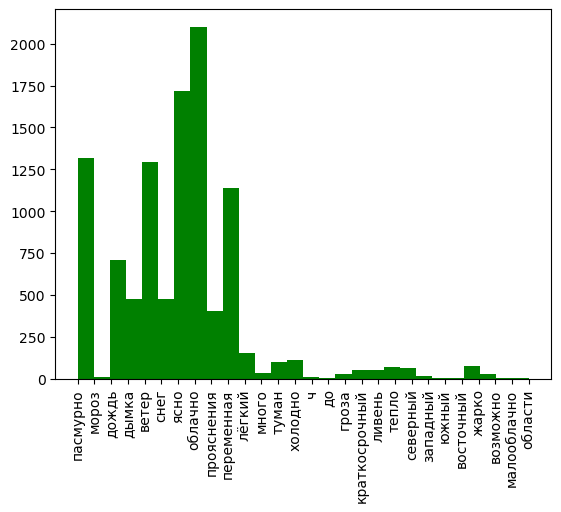

Размер датафрейма: (2928, 91)
INFO: Создание набора данных
(2928, 90) (2928,)


In [39]:
path_to_test_df = './test_dataset.csv'
sol = Preprocessor(path_to_test_df)

# Поскольку работаем с временными рядам, то можно заполнить пропущенные значения значениями предыдущих строк
sol.fill_empty_cells()

# Поскольку нам необходимо предсказывать потребление электричества на сутки вперед, то сдвинем метки на 24 строки вверх
# sol.shift_target()

# Добавим полезные фичи
sol.add_features()

# Категориальные столбцы парсим и в OHE
sol.one_hot_encoding()

# Создаем наборы данных
X, y = sol.create_x_y(train_test=False)

In [33]:
# Загружаем модель
loaded_model = CatBoostRegressor()
loaded_model.load_model('./models/best_catboost_model.bin')

In [40]:
# Предсказываем и считаем метрику
predictions = loaded_model.predict(X)
get_metrics(y, predictions)

MSE: 2.19
MAE: 0.74
MAPE: 0.00
R2_score: 1.00


(0.7351135189594201, 0.001939240238738007, 0.9995653597290352)

In [41]:
df_sub = pd.read_csv(path_to_test_df)
df_sub['predict'] = predictions
df_sub = df_sub[['date', 'target', 'predict']]
df_sub.head()

,date,target,predict
0,2023-04-01,479.282,486.547166
1,2023-04-01,445.182,451.862189
2,2023-04-01,424.225,433.808333
3,2023-04-01,413.866,425.697136
4,2023-04-01,408.146,411.463857


## Выводы

Модель работает довольно хорошо, узнать у оргов ответы на вопросы ниже

## TODO

1. Попробовать трансформеры, rnn
2. Добавить в препроцессинг нормализацию данных

## Questions

1. Какого размера приватный датасет?

* Чтобы предсказывать потребление электроэнергии на сутки вперед, нужно иметь инфу о предыдущих месяцах.
* А если приватный датасет состоит из 1 дня?


2. В приватном датасете по идее должен быть столбец target, поскольку постольку. Но кто его знает будет этот столбец или нет

3. Главный вопрос: Нужно предсказать потребление электроэнергии на следующие сутки в строках текущего дня или в строках следующего дня?
* То есть как работает метрика: смотрит на target и predict текущего дня или смотрит на target текущего дня и predict следующего дня, т.к. нужно предсказать потребление электроэнергии на следующие сутки 


4. Нужен лидерборд

In [45]:
get_metrics(y, df_sub['predict']) # Предсказания на следующие сутки в строках текущего дня

MSE: 2.19
MAE: 0.74
MAPE: 0.00
R2_score: 1.00


(0.7351135189594201, 0.001939240238738007, 0.9995653597290352)

In [43]:
get_metrics(df_sub['target'], df_sub['predict']) # Предсказания на сегодня, с учетом того, что 

MSE: 286.77
MAE: 11.88
MAPE: 0.03
R2_score: 0.94


(11.882310339564995, 0.027884966910402507, 0.9437174139300555)

In [44]:
get_metrics(df_sub['target'], y) # бейзлайн_1 Предсказать предыдущий день

MSE: 288.06
MAE: 11.91
MAPE: 0.03
R2_score: 0.94


(11.908866803278688, 0.027995878384396104, 0.9434641864705954)